In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [4]:
data = pd.read_csv("dfDL.csv")

In [5]:
data['volume'] = data['volume'].apply(lambda x: pd.NA if x == -1 else x)
data['average'] = data['average'].apply(lambda x: pd.NA if x == -1 else x)
data['barCount'] = data['barCount'].apply(lambda x: pd.NA if x == -1 else x)

# Check the modifications again
data.head()

,date,open,high,low,close,volume,average,barCount
0,2023-03-17 08:30:00-05:00,4109.00,4539.25,4103.00,4539.25,<NA>,<NA>,<NA>
1,2023-03-17 09:00:00-05:00,4114.75,4118.75,4073.75,4082.00,<NA>,<NA>,<NA>
2,2023-03-17 10:00:00-05:00,4082.00,4086.00,4063.75,4070.00,<NA>,<NA>,<NA>
3,2023-03-17 11:00:00-05:00,4070.00,4093.75,4069.75,4081.75,<NA>,<NA>,<NA>
4,2023-03-17 12:00:00-05:00,4081.75,4091.75,4079.50,4085.75,<NA>,<NA>,<NA>


In [6]:
data_cleaned = data.drop(columns=['volume', 'average', 'barCount'])


In [7]:
# Convert 'date' column to UTC to handle timezone-aware datetime issues
data_cleaned['date'] = pd.to_datetime(data_cleaned['date'], utc=True)

# Extract date-related features
data_cleaned['year'] = data_cleaned['date'].dt.year
data_cleaned['month'] = data_cleaned['date'].dt.month
data_cleaned['day'] = data_cleaned['date'].dt.day
data_cleaned['hour'] = data_cleaned['date'].dt.hour
data_cleaned['dayofweek'] = data_cleaned['date'].dt.dayofweek

# Display the updated dataframe with new features
data_cleaned.head()


,date,open,high,low,close,year,month,day,hour,dayofweek
0,2023-03-17 13:30:00+00:00,4109.00,4539.25,4103.00,4539.25,2023,3,17,13,4
1,2023-03-17 14:00:00+00:00,4114.75,4118.75,4073.75,4082.00,2023,3,17,14,4
2,2023-03-17 15:00:00+00:00,4082.00,4086.00,4063.75,4070.00,2023,3,17,15,4
3,2023-03-17 16:00:00+00:00,4070.00,4093.75,4069.75,4081.75,2023,3,17,16,4
4,2023-03-17 17:00:00+00:00,4081.75,4091.75,4079.50,4085.75,2023,3,17,17,4


In [8]:
# Scale the relevant features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_cleaned[['open', 'high', 'low', 'close']])

# Convert the scaled data back to a dataframe
data_scaled_df = pd.DataFrame(data_scaled, columns=['open', 'high', 'low', 'close'])
data_scaled_df['date'] = data_cleaned['date']  # Keep the date for indexing

# Display the scaled data
data_scaled_df.head()


,open,high,low,close,date
0,-1.774271,-0.473482,-1.688851,-0.423107,2023-03-17 13:30:00+00:00
1,-1.756191,-1.819326,-1.778185,-1.864046,2023-03-17 14:00:00+00:00
2,-1.859170,-1.924145,-1.808727,-1.901862,2023-03-17 15:00:00+00:00
3,-1.896903,-1.899341,-1.790402,-1.864834,2023-03-17 16:00:00+00:00
4,-1.859956,-1.905742,-1.760624,-1.852229,2023-03-17 17:00:00+00:00


In [10]:
# Function to create sequences
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i])  # Inputs
        y.append(data[i, 3])  # Target (closing price)
    return np.array(X), np.array(y)

# Load your data
# data = pd.read_csv('your_data.csv')  # Adjust path as necessary

# Preprocess your data: assume 'open', 'high', 'low', 'close' columns
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[['open', 'high', 'low', 'close']])

# Create sequences
n_steps = 10
X, y = create_sequences(data_scaled, n_steps)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(n_steps, 4)),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=20, verbose=1, validation_split=0.2)

# Optionally, evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')


Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3030 - val_loss: 0.0287
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0244 - val_loss: 0.0187
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0244 - val_loss: 0.0171
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0178 - val_loss: 0.0166
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0174 - val_loss: 0.0164
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0168 - val_loss: 0.0160
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0202 - val_loss: 0.0151
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0207 - val_loss: 0.0152
Epoch 9/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0181 - val_loss: 0.0151
Epoch 10/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0288 - val_loss: 0.0169
Epoch 11/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0214 - val_loss: 0.0146
Epoch 12/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0224 - val_loss: 0.0145


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


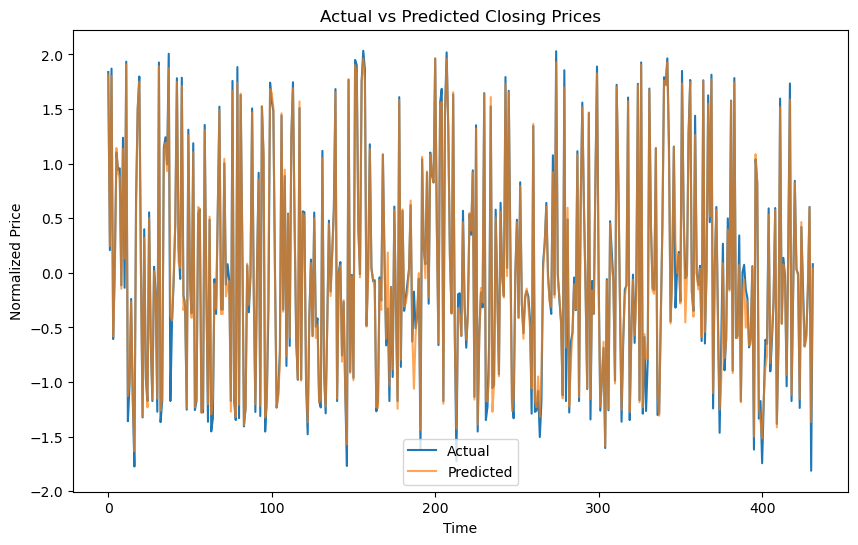

In [11]:
y_test_pred = model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_test_pred, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Time')
plt.ylabel('Normalized Price')
plt.legend()
plt.show()

In [12]:
import tensorflow as tf

In [13]:
model.save('my_model.keras')

In [14]:
model = tf.keras.models.load_model('my_model.keras')

In [15]:
def forecast_future_prices(model, initial_data, steps, scaler):
    current_batch = initial_data[-n_steps:].reshape(1, n_steps, 4)  # Reshape for the model
    future_predictions = []

    for i in range(steps):
        # Predict the next step and retrieve the scaled value
        future_pred = model.predict(current_batch)[0][0]  # Assuming model outputs one value
        
        # Append the prediction to future_predictions
        future_predictions.append(future_pred)  # Store prediction directly
        
        # Update only the close price in the last timestep of the current batch
        new_row = current_batch[0, -1, :].copy()  # Copy the last row from the last timestep
        new_row[3] = future_pred  # Update the close price (assuming it's at index 3)
        
        # Update the batch to include the new timestep and exclude the oldest data point
        current_batch = np.append(current_batch[:, 1:, :], [new_row.reshape(1, 4)], axis=1)
    
    # Prepare future_predictions for inverse transformation
    future_predictions_array = np.array(future_predictions).reshape(-1, 1)  # Reshape to (n, 1)
    # Inverse transform the predictions
    future_predictions_scaled = scaler.inverse_transform(np.concatenate([np.zeros((len(future_predictions_array), 3)), future_predictions_array], axis=1))[:, 3]
    
    return future_predictions_scaled

# Loading model and predicting as before
model = tf.keras.models.load_model('my_model.keras')
last_steps = data_scaled[-n_steps:]  # Get the last 'n_steps' data
predicted_prices = forecast_future_prices(model, last_steps, 30, scaler)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


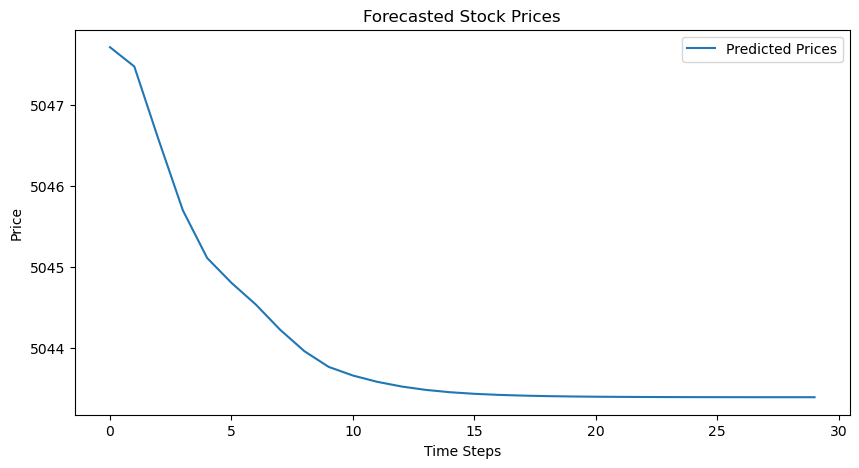

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(predicted_prices, label='Predicted Prices')
plt.title('Forecasted Stock Prices')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()